In [1]:
!pip install kagglehub

In [10]:
import kagglehub
import pandas as pd

# 1. Baixe o dataset (ele retorna o caminho para a pasta onde os arquivos foram baixados)
path = kagglehub.dataset_download("marlesson/news-of-the-site-folhauol")

# O caminho completo para o arquivo será algo como: '{path}/articles.csv'
file_path = f"{path}/articles.csv"

# 2. Abra o arquivo local com Pandas
df = pd.read_csv(file_path)

print(df.head())

                                               title  \
0  Lula diz que está 'lascado', mas que ainda tem...   
1  'Decidi ser escrava das mulheres que sofrem', ...   
2  Três reportagens da Folha ganham Prêmio Petrob...   
3  Filme 'Star Wars: Os Últimos Jedi' ganha trail...   
4  CBSS inicia acordos com fintechs e quer 30% do...   

                                                text        date   category  \
0  Com a possibilidade de uma condenação impedir ...  2017-09-10      poder   
1  Para Oumou Sangaré, cantora e ativista malines...  2017-09-10  ilustrada   
2  Três reportagens da Folha foram vencedoras do ...  2017-09-10      poder   
3  A Disney divulgou na noite desta segunda-feira...  2017-09-10  ilustrada   
4  O CBSS, banco da holding Elopar dos sócios Bra...  2017-09-10    mercado   

  subcategory                                               link  
0         NaN  http://www1.folha.uol.com.br/poder/2017/10/192...  
1         NaN  http://www1.folha.uol.com.br/ilustrada/

In [118]:
#Crie um ranking das organizações que mais apareceram na seção "Mercado" no primeiro trimestre de 2015.
df['date'] = pd.to_datetime(df.date)
df_filtrado = df[(df["date"].dt.year == 2015) &
             (df["date"].dt.month.isin([1, 2, 3])) & 
             (df["category"].str.lower() == "mercado")]


In [119]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2111 entries, 99055 to 167025
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   title        2111 non-null   object        
 1   text         2111 non-null   object        
 2   date         2111 non-null   datetime64[ns]
 3   category     2111 non-null   object        
 4   subcategory  0 non-null      object        
 5   link         2111 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 115.4+ KB


In [123]:
from transformers import BertForTokenClassification, DistilBertTokenizerFast, pipeline
model = BertForTokenClassification.from_pretrained('monilouise/ner_pt_br')
tokenizer = DistilBertTokenizerFast.from_pretrained('neuralmind/bert-base-portuguese-cased'
                                                    , model_max_length=512
                                                    , do_lower_case=False
                                                    )
ner_pipeline = pipeline('ner', 
                        model=model, 
                        tokenizer=tokenizer, 
                        aggregation_strategy="simple", 
                        framework="pt", 
                        device="cuda:0")


Some weights of the model checkpoint at monilouise/ner_pt_br were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.
The tokenizer class you load from this check

In [148]:
from collections import deque

def extract_entities(text, max_tokens=512):
    entities = []
    words = text.split()
    blocks = deque()
    
    tokenized_texts = []
    for word in words:
        blocks.append(word)
        text_truncated = " ".join(blocks)
        tokens = tokenizer(text_truncated, return_tensors="pt", truncation=False)
        
        if tokens.input_ids.shape[1] >= max_tokens:
            blocks.pop()
            text_truncated = " ".join(blocks)
            tokenized_texts.append(text_truncated)
            blocks = deque([word])

    tokenized_texts.append(" ".join(blocks))  
    entities.extend(ner_pipeline(tokenized_texts, batch_size=32)) 
    return entities

In [149]:
from tqdm.auto import tqdm

from tqdm import tqdm

all_entities = [entity for text in tqdm(df_filtrado['text']) for entity in extract_entities(text)]
all_entities = [item for sublist in all_entities for item in sublist]


100%|██████████| 2111/2111 [13:39<00:00,  2.57it/s]


In [150]:
all_entities

[{'entity_group': 'PUB',
  'score': np.float32(0.97653186),
  'word': 'Ana',
  'start': 154,
  'end': 157},
 {'entity_group': 'PUB',
  'score': np.float32(0.9472861),
  'word': '##tel',
  'start': 157,
  'end': 160},
 {'entity_group': 'PUB',
  'score': np.float32(0.98799914),
  'word': 'Agência Nacional de',
  'start': 162,
  'end': 181},
 {'entity_group': 'PUB',
  'score': np.float32(0.98365694),
  'word': 'Telecomunicações',
  'start': 182,
  'end': 198},
 {'entity_group': 'LOC',
  'score': np.float32(0.93016416),
  'word': 'Brasil',
  'start': 389,
  'end': 395},
 {'entity_group': 'ORG',
  'score': np.float32(0.9620528),
  'word': 'Claro',
  'start': 818,
  'end': 823},
 {'entity_group': 'ORG',
  'score': np.float32(0.60725194),
  'word': 'grupo',
  'start': 828,
  'end': 833},
 {'entity_group': 'ORG',
  'score': np.float32(0.7203845),
  'word': 'América',
  'start': 834,
  'end': 841},
 {'entity_group': 'ORG',
  'score': np.float32(0.97052306),
  'word': 'Móvil',
  'start': 842,
  

In [151]:
import pandas as pd

df_entities = pd.DataFrame(all_entities)

df_orgs = df_entities[df_entities['entity_group'] == "ORG"]

df_orgs["count"] = df_orgs["word"].map(df_orgs["word"].value_counts())


df_unique_orgs = df_orgs.groupby("word", as_index=False).first()

sorted = df_unique_orgs.sort_values(by=["count"], ascending=[False])

sorted.head(20)


C:\Users\belch\AppData\Local\Temp\ipykernel_50396\2346614589.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_orgs["count"] = df_orgs["word"].map(df_orgs["word"].value_counts())


,word,entity_group,score,start,end,count
2157,Folha,ORG,0.649513,16,21,607
3006,O,ORG,0.955168,988,989,372
1513,Brasil,ORG,0.884909,1039,1045,211
4081,s,ORG,0.903501,91,92,185
517,##i,ORG,0.622377,989,990,168
1505,Brad,ORG,0.955614,994,998,164
429,##esco,ORG,0.859656,998,1002,160
1354,B,ORG,0.708539,757,758,152
180,##S,ORG,0.471622,131,132,129
3472,Sete,ORG,0.984839,535,539,124


In [154]:
ranking = [entity['word'] for entity in all_entities if entity['entity_group'] ==  "ORG" and len(entity['word']) > 2 and  "##" not in entity['word'] and entity['word'] != "Folha"]

In [179]:
from typing import Counter
top_20 = pd.DataFrame(Counter(ranking).most_common(20), columns=['word', 'count'])



In [186]:
top_20_ordered = top_20.sort_values(by="count", ascending=True)


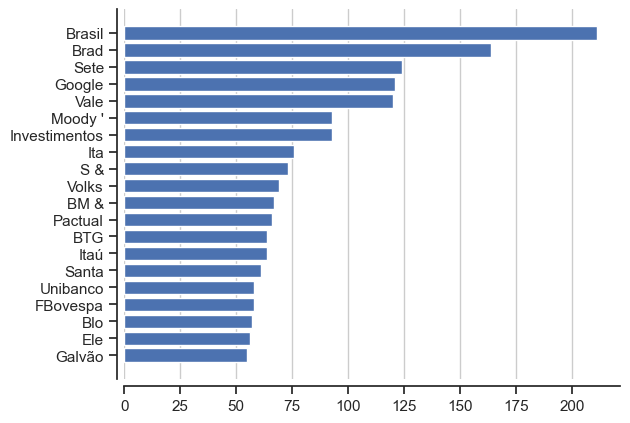

In [187]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")
ax = plt.barh(top_20_ordered["word"], top_20_ordered["count"])
sns.despine(offset=5)
plt.grid(":", axis='x')
plt.xticks(rotation=0);


In [188]:
Counter(ranking).most_common()

[('Brasil', 211),
 ('Brad', 164),
 ('Sete', 124),
 ('Google', 121),
 ('Vale', 120),
 ('Investimentos', 93),
 ("Moody '", 93),
 ('Ita', 76),
 ('S &', 73),
 ('Volks', 69),
 ('BM &', 67),
 ('Pactual', 66),
 ('BTG', 64),
 ('Itaú', 64),
 ('Santa', 61),
 ('FBovespa', 58),
 ('Unibanco', 58),
 ('Blo', 57),
 ('Ele', 56),
 ('Galvão', 55),
 ('Apple', 48),
 ('Banco do', 47),
 ('Facebook', 46),
 ('Corretora', 46),
 ('Times', 45),
 ("McDonald '", 42),
 ('Vivo', 41),
 ('Banco', 41),
 ('Amazon', 40),
 ('Tele', 39),
 ('Telecom', 38),
 ('Sul', 37),
 ('OAS', 36),
 ("Standard & Poor '", 35),
 ('King', 33),
 ('Engenharia', 33),
 ('Petrobras', 31),
 ('Twitter', 31),
 ('Bras', 31),
 ('Claro', 30),
 ('Suisse', 30),
 ('Ford', 29),
 ('Grupo', 28),
 ('Credit', 28),
 ('Açúcar', 28),
 ('Toyo', 27),
 ('Queiroz', 27),
 ('Yahoo', 26),
 ('Paulo', 26),
 ('Energia', 25),
 ('Partners', 25),
 ('Reut', 24),
 ('Embra', 24),
 ('Data', 24),
 ('Camargo', 23),
 ('Força', 23),
 ('Mit', 22),
 ('Associados', 22),
 ('Letras', 22),


In [ ]:
!pip install wordcloud

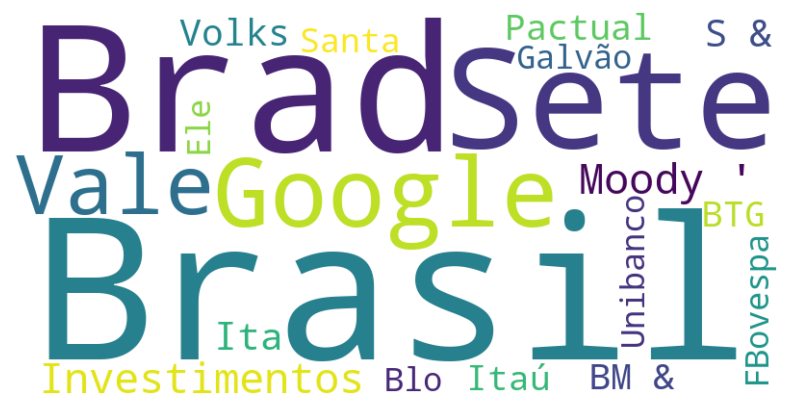

In [189]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="ticks")

# Contagem das palavras mais comuns
top_20 = dict(Counter(ranking).most_common(20))

# Criando a WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis")
wordcloud.generate_from_frequencies(top_20)

# Plotando a WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Remove eixos
plt.show()

In [140]:

org_entities = [ent for ent in all_entities if ent.get("entity_group") == "ORG"]